<a id='begin'></a>
# Recurrent Neural Networks

In this notebook we're going to solve the task of part-of-speech (POS) tagging using RNNs

In [1]:
import numpy as np
import nltk

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Embedding
from keras.layers import Input, LSTM, SimpleRNN, TimeDistributed, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


Set style

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Random seed is put here just for the sake of reproducibility

In [3]:
np.random.seed(41)

# Loading data

In this demo we're going to use [NLTK](http://www.nltk.org/) python library which provides lots of function to work with natural language and text corpuses. 

## Preparation - setting NLTK

Downloading Brown [[1](http://www.hit.uib.no/icame/brown/bcm.html#bc2), [2](https://en.wikipedia.org/wiki/Brown_Corpus)] corpus with part-of-speech tagging and list of tags used.

In [4]:
nltk.download("brown")
nltk.download("tagsets")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

Below there is a full list of tags for Brown corpus. As one can see, there are quite a few of them (about a hundred).

In [5]:
# nltk.help.brown_tagset()

Thus for simplicity we're going to use *Universal tagset*[[1](http://www.lrec-conf.org/proceedings/lrec2012/pdf/274_Paper.pdf), [2](https://github.com/slavpetrov/universal-pos-tags)] here. This tagset was suggested by Google (also they provide rules to cast all famous tegsets into universal) and has only 12 categories

Let's download it

In [6]:
nltk.download("universal_tagset")

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

And take a look into [categories](http://www.nltk.org/book/ch05.html)

| Tag | Meaning | English Examples
| :- | :- | :-
| ADJ | adjective | new, good, high, special, big, local
| ADP | adposition | on, of, at, with, by, into, under
| ADV | adverb | really, already, still, early, now
| CONJ| conjunction | and, or, but, if, while, although
| DET | determiner, article | the, a, some, most, every, no, which
| NOUN | noun | year, home, costs, time, Africa
| NUM | numeral | twenty-four, fourth, 1991, 14:24
| PRT | particle | at, on, out, over per, that, up, with
| PRON | pronoun | he, their, her, its, my, I, us
| VERB | verb | is, say, told, given, playing, would
| . | punctuation marks | . , ; !
| X | other | ersatz, esprit, dunno, gr8, univeristy

## Brief analysis of Brown corpus

First of all, let's see how many words and sentences we have:

In [7]:
total_number_of_words = len(nltk.corpus.brown.words())
sentences_lengths_distribution = list(map(lambda sen: len(sen), nltk.corpus.brown.sents()))
print("Words:", total_number_of_words)
print("Sentences:", len(sentences_lengths_distribution))

Words: 1161192
Sentences: 57340


In [8]:
MAX_SEQUENCE_LENGTH = np.max(sentences_lengths_distribution)
MEAN_SEQUENCE_LENGTH = np.mean(sentences_lengths_distribution)
print("Maximum sentence length:", MAX_SEQUENCE_LENGTH)
print("Mean sentence length:", np.round(MEAN_SEQUENCE_LENGTH, 2))

Maximum sentence length: 180
Mean sentence length: 20.25


Sentence lenghts distribution

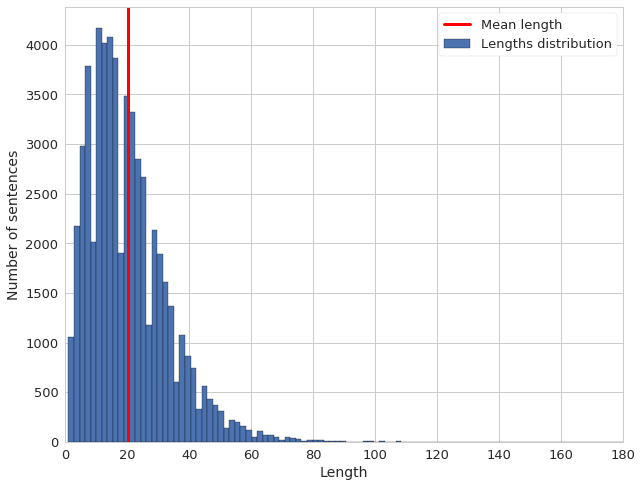

In [9]:
plt.hist(sentences_lengths_distribution, bins=100, label="Lengths distribution", edgecolor="k")
plt.xlim([0, MAX_SEQUENCE_LENGTH])
ylims = plt.ylim()
plt.plot([MEAN_SEQUENCE_LENGTH, MEAN_SEQUENCE_LENGTH], [ylims[0], ylims[1]], c="r", lw=3, label="Mean length")
plt.ylim([ylims[0], ylims[1]])
plt.legend()
plt.xlabel("Length", fontsize=14)
plt.ylabel("Number of sentences", fontsize=14)
plt.show()

Secondly, let's see onto words distribution over categories

In [10]:
brown_tagged = nltk.corpus.brown.tagged_words(tagset='universal')
tag_fd = nltk.FreqDist(tag for (word, tag) in brown_tagged)
most_common_pos = tag_fd.most_common()
print(most_common_pos)
most_common_pos = list(zip(*most_common_pos))

[('NOUN', 275558), ('VERB', 182750), ('.', 147565), ('ADP', 144766), ('DET', 137019), ('ADJ', 83721), ('ADV', 56239), ('PRON', 49334), ('CONJ', 38151), ('PRT', 29829), ('NUM', 14874), ('X', 1386)]


Visualizing

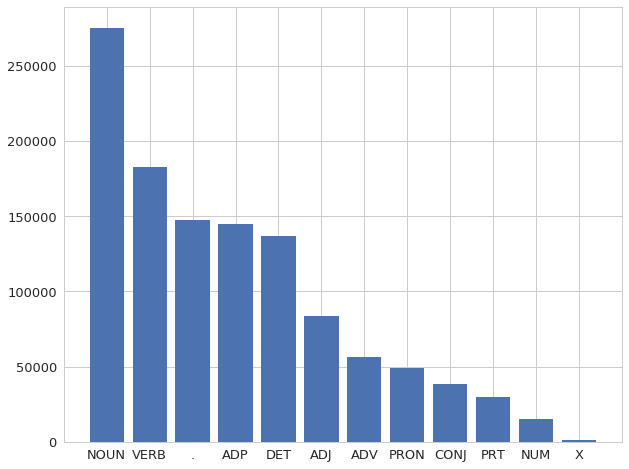

In [11]:
plt.bar(np.arange(len(most_common_pos[0])), most_common_pos[1])
plt.xlim([-1, len(most_common_pos[0])])
plt.xticks(np.arange(len(most_common_pos[0])), 
           most_common_pos[0]);

# Data pre-processing

Read tagged corpus sentence by sentence

In [12]:
data = nltk.corpus.brown.tagged_sents(tagset="universal")

In [13]:
print("Example of sentence:")
data[0]

Example of sentence:


[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

## Enumeration encoding

Next goal is to transform our corpus into numerical representation.

First step it to encode all the words enumeration encoding - in other words we're just goind to enumerate the vocabulary.

For that purpose we're going to build two vocabularies:
* Words vocabulary $-$ array that contains all the words that occur in the corpues
* Tags vocabulary $-$ array with all possible part-of-speech tags (12 tags from universal tagset)

In [14]:
words_vocabulary = np.unique(nltk.corpus.brown.words())
tags_vocabulary = np.unique(list(zip(*nltk.corpus.brown.tagged_words(tagset="universal")))[1])

In [15]:
print("Size of words vocabulary:", len(words_vocabulary))

Size of words vocabulary: 56057


Now let's construct python dictionary from that vocabularies. These dictionaries will be a lookup tables in which we're going to look while looping over corpus and transforming it from words to numbers.

In [16]:
words_index = dict(zip(words_vocabulary, np.arange(1, len(words_vocabulary) + 1)))
tags_index = dict(zip(tags_vocabulary, np.arange(1, len(tags_vocabulary) + 1)))

Important thing here is that we enumerate all words and tags staring from $1$. The reason is that we're going to pad all the sequences with $0$ to have them with equal lengths. Actually it is the constraint of the Keras (and any other deep learning library which works with tensors). Keras requires to have all inputs to be fed as one tensor. And to form a tensor all dimensions should have the same number of components. Thus all the sequences should be of the same length.

But at the same time Keras provides nice and easy way to overcome this restriction. One can use *masked* input which means that all the zeros in the input sequences will be treated as empty places and predictions at these places won't be taken in account during the loss computation.

Now let's just iterate over the corpus and replace every word with its index in the lookup table

In [17]:
sentences_indexed = []
tags_indexed = []
for sentences in data:
    sent_ind = []
    tag_ind = []
    for word, tag in sentences:
        sent_ind.append(words_index[word])
        tag_ind.append(tags_index[tag])
    sentences_indexed.append(sent_ind)
    tags_indexed.append(tag_ind)

And then pad these sequences to the same length (equal to the maximum length of the sentence)

In [18]:
sentences_indexed = pad_sequences(sentences_indexed, maxlen=MAX_SEQUENCE_LENGTH)
tags_indexed = pad_sequences(tags_indexed, maxlen=MAX_SEQUENCE_LENGTH)

Now we have each object of the corpus in the following form:

In [19]:
print("Sentence:\n", sentences_indexed[0])
print("--------------------------------------------------------------------------")
print("Tags:\n", tags_indexed[0])

Sentence:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0 17591
  8187  5896  8688 10433 47062  8137 204

## Word embeddings

Next (and one of the most important) step is to embed our words into the low-dimensional space that will reflect similarity notion between words. A brief introduction to word-vectors can be found here [[1](http://cs224d.stanford.edu/lecture_notes/notes1.pdf), [2](http://sebastianruder.com/word-embeddings-1/index.html)].

Here we're going to use word embedding pre-trained on full English Wikipedia dump using Word2Vec with Skip-gram architecture, negative sampling loss function and dimension of 100.

First of all, let's simply load all the embedding space in the same dictionary format. To complete this step you need to have $\text{wiki_w2v.vec}$ in the same folder with this notebook. The downloading is done by the following command:

In [20]:
!wget https://www.dropbox.com/s/9pu6mt769kj8803/pretrained_embedding.tar.gz
!tar -xvzf pretrained_embedding.tar.gz

--2017-10-22 19:54:55--  https://www.dropbox.com/s/9pu6mt769kj8803/pretrained_embedding.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/a8SjUVCuFbZIYibRtMyShxbnpsWavLvoDoevo6pDz8P2RWLkyUBIhsIuRmYawvrh/file [following]
--2017-10-22 19:54:56--  https://dl.dropboxusercontent.com/content_link/a8SjUVCuFbZIYibRtMyShxbnpsWavLvoDoevo6pDz8P2RWLkyUBIhsIuRmYawvrh/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6, 2620:100:6022:6::a27d:4206
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 866689471 (827M) [application/octet-stream]
Saving to: 'pretrained_embedding.tar.gz'

pretrained_embeddin 100%[===================>] 826.54M  5

In [21]:
embeddings_index = {}
f = open("./wiki_w2v.vec")
f.readline()
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Embedding dimension can be found as a number of coordinates for arbitrary word.

In [22]:
EMBEDDING_DIM = len(embeddings_index["the"])

Word-vectors for word is just a 100-dimensional vector of numbers

In [23]:
print("\"the\"\n", embeddings_index["the"])

"the"
 [-0.139744    0.20813    -0.118162    0.061692   -0.002767    0.19353899
 -0.137596   -0.081763    0.10003    -0.023349   -0.35396001 -0.086922
 -0.10971     0.14912     0.24900199  0.090235   -0.175136    0.100408
  0.227097   -0.38284701  0.20857599  0.203307   -0.060234    0.137311
  0.100868   -0.005166   -0.06901    -0.29135701 -0.077014    0.077363
 -0.67388499  0.33003101 -0.32567599 -0.003312   -0.069184   -0.016198
 -0.20462    -0.01192     0.105787    0.039009    0.38602901  0.014063
 -0.34556401 -0.185229   -0.19212601 -0.051685   -0.055161   -0.279562
 -0.31859699 -0.17527901  0.223395   -0.40426299  0.030896   -0.27991199
 -0.018625   -0.072526    0.0099      0.31887901  0.26463899 -0.157149
 -0.41845399  0.030546    0.30279899  0.126863    0.057413   -0.278595
 -0.49134201 -0.37145299  0.37209201 -0.18141     0.34714001  0.076957
 -0.20196401 -0.257523    0.095072    0.019826   -0.176595    0.39072999
  0.165888    0.17529801 -0.37434199 -0.088488    0.097903   -0.

Now let's filter out only those words that are in our corpus. If we will find word from corpus that is not in the embedding vocabulary then we're going to assign it with all zeros (yes, stupid solution that inevitably put some error, but for now we're ok with this)

In [24]:
embedding_matrix = np.zeros((len(words_index) + 1, EMBEDDING_DIM))
for word, i in words_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Further we're going to initialize input layer of the network with this embeddings

# RNN-based part-of-speech tagger

In "strict" mathematical formulation we need to solve a sequence-2-sequence classification tasks. Let's find out what each word here means:

* **Seq-2-Seq**. This paradigm stands for the situation when we have a sequence of features as an input and we need to predict also a sequence. In general case length of the sequences can be different and we need to find out how to align them properly. But in our case the lengths of the sequences have to be the same from the nature of the task.
* **Classification**. Actually assigning each word with the part-of-speech tag is nothing but choosing between 12 possible labels for each timestep. Thus we have the classification task with 12 classes.

## Train/Validation splitting

Let's come up with our final training data

Every element of $\text{X}$ is just the sequence of word numbers in dictionary that corresponds to the words in real sentence.

In [25]:
X = sentences_indexed

$y$ need to be [one-hot-encoded](https://en.wikipedia.org/wiki/One-hot) vectors as we usually do with NN

In [26]:
y = np.array([to_categorical(seq, len(tags_vocabulary) + 1) for seq in tags_indexed])

Finally one training sample looks the following:

In [27]:
print("Feature sequence:\n", X[0])
print("--------------------------------------------------------------------------")
print("Label sequence:\n", y[0])

Feature sequence:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0 17591
  8187  5896  8688 10433 47062  

Let's split our data into train and validation in fraction of $\frac{1}{4}$.

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21)

## Defining model architecture

The first layer is just the input layer that takes prepared sequences

In [29]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), 
                       dtype='int32', 
                       name="Input")

Next layer is Keras Embedding layer. In fact this layer just converts every enumerated word from input into its word-vector using lookup table.

Arguments are the following:
* input_dim $-$ size of the input vocabulary
* output_dim $-$ dimension of the embedding
* **weights** $-$ actual embedding matrix; here we have pre-trained one, but actually can learn it from scratch if we have big enough corpus
* input_length $-$ the lenght of the sequences in the input
* **trainable** $-$ whether we want to train this weigths or not; because we already have pre-trained word embedding we don't want to do it
* **mask_zero** $-$ setting this option to $\text{True}$ means all the zeros in the input will be treated as empty places (as we discussed before) and the mask will be created (and passed forward through all layers)
* name $-$ name of the layer to display

In [30]:
embedded_sequences = Embedding(input_dim=len(words_index) + 1,
                               output_dim=EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False, 
                               mask_zero=True, 
                               name="Embedding")(sequence_input)

After this layer each sentence is represented as a sequence of length $180$ where each element is $100$-dimensional vector.

Now let's create main "logical" part for our tagger - LSTM layer. As we want to do sequence-2-sequence learning, we require our layer to return sequences. It means that for every train sentence it will return sequence of the same length ($180$) where each object is the new feature vector generated by $128$ LSTM-cells (and thus feature dimensionality if $128$)

In [31]:
recurrent = LSTM(units=128, 
                 return_sequences=True, 
                 name="LSTM")(embedded_sequences)

After obtaining new meaningful representation of the sentence which accounts for recurrent relations inside it, we need to do a classification for each timestep (out of $180$). For this purpose we're going to use special wrapper over a simple $\text{Dense}$ layer which called $\text{TimeDistributed}$ and just pass through fully-conected layer each element of the sequence.

Here the number of nodes is chosen to be $128$ because it seems to be enough for this task. But one can experiment with multilayer classification part of the network

Also we're going to use ReLU activation function because it is less exposed to vanishing gradient problem.

In [32]:
dense = TimeDistributed(Dense(units=128, 
                              activation='relu'), 
                        name="Dense")(recurrent)

And the final layer is usual softmax $\text{Dense}$ layer (with the same $\text{TimeDistributed}$ wrapper)

In [33]:
out = TimeDistributed(Dense(units=len(tags_vocabulary) + 1, 
                            activation='softmax'), 
                      name="Softmax")(dense)

Let's finally build all the pieces together and create a Keras model

In [34]:
model = Model(inputs=[sequence_input], 
              outputs=[out])

And see how it looks like:

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 180)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 180, 100)          5605800   
_________________________________________________________________
LSTM (LSTM)                  (None, 180, 128)          117248    
_________________________________________________________________
Dense (TimeDistributed)      (None, 180, 128)          16512     
_________________________________________________________________
Softmax (TimeDistributed)    (None, 180, 13)           1677      
Total params: 5,741,237
Trainable params: 135,437
Non-trainable params: 5,605,800
_________________________________________________________________


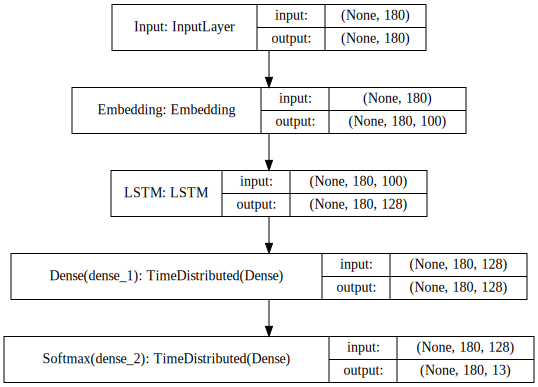

In [36]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Now it's time to compile the model. Remember here, that we passed the mask for the input through all the network from the embedding layer and loss will be calculated in correspondance with this mask.

* **optimizer** $-$ here we use accelerated gradient descent algorithm with special adaptive way of choosing learning rate; for more details see this great [overview](http://sebastianruder.com/optimizing-gradient-descent/) of gradient descent optimization algorithms.
* **loss** $-$ usual choice for multiclass classification is softmax output layer in combination with categotical crossentropy loss function which is
$$
\mathcal{L}(\text{true}, \text{pred}) = -\sum_{j=1}^{k}\text{true}_j \cdot \log \{\text{pred}_j\}
$$
* **metrics** $-$ additional metrics that we're going to trace while training; it doesn't influence training process at all

In [37]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Now we're finally ready to train!

* nb_epoch $-$ number of epochs to train. here we choose 10; one may condiser using some stopping criterias
* **batch_size** $-$ parameter that controls how frequent do we update gradient; with $\text{batch_size}=1$ optimization is nothing but pure Stohastic Gradient Descent (update gradient after passing each one object); with $\text{batch_size}=\text{number of objects}$ it will be usual Gradient Descent which updates gradient only after passing all objects. Choosing value between this two one can control speed and convergence of training process.

## Training & Evaluation

In [38]:
%%time
hist = model.fit(X_train, y_train, 
                 epochs=10, 
                 batch_size=256, 
                 validation_data=(X_val, y_val))

Train on 45872 samples, validate on 11468 samples
Epoch 1/10
45872/45872 [==============================] - 95s - loss: 1.1762 - acc: 0.6197 - val_loss: 0.6033 - val_acc: 0.8023
Epoch 2/10
45872/45872 [==============================] - 94s - loss: 0.5334 - acc: 0.8224 - val_loss: 0.5029 - val_acc: 0.8297
Epoch 3/10
45872/45872 [==============================] - 95s - loss: 0.4738 - acc: 0.8406 - val_loss: 0.4599 - val_acc: 0.8434
Epoch 4/10
45872/45872 [==============================] - 97s - loss: 0.4452 - acc: 0.8483 - val_loss: 0.4402 - val_acc: 0.8486
Epoch 5/10
45872/45872 [==============================] - 98s - loss: 0.4269 - acc: 0.8534 - val_loss: 0.4259 - val_acc: 0.8522
Epoch 6/10
45872/45872 [==============================] - 99s - loss: 0.4135 - acc: 0.8574 - val_loss: 0.4165 - val_acc: 0.8555
Epoch 7/10
45872/45872 [==============================] - 98s - loss: 0.4033 - acc: 0.8606 - val_loss: 0.4065 - val_acc: 0.8580
Epoch 8/10
45872/45872 [==============================

Let's see evolution of loss throughout the training

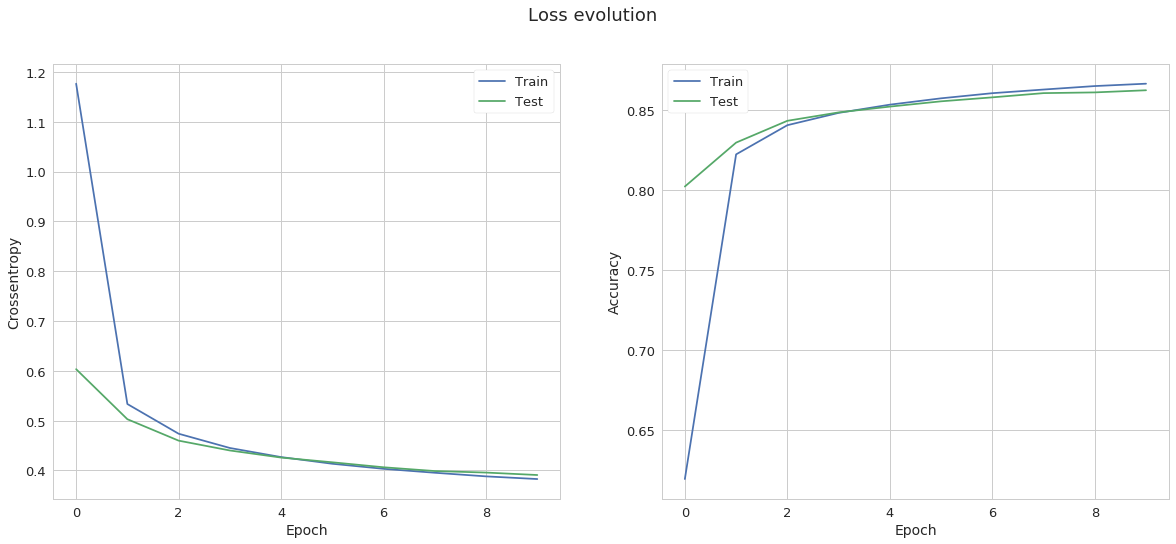

In [39]:
plt.figure(figsize=(20, 8))
plt.suptitle("Loss evolution", fontsize=18)

plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)

plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.plot(hist.history["val_acc"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14);

And final accuracy of classification:

In [40]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_val)

Let's define masked accuracy function (for now Keras doesn't support metrics calculation with mask)

In [41]:
def masked_accuracy(y_true, y_pred):
    right = 0
    total = 0
    for i in range(len(y_pred)):
        idxs = np.argmax(y_true[i], axis=-1) != 0
        total += np.sum(idxs)
        right += np.sum(np.argmax(y_true[i], axis=-1)[idxs] == np.argmax(y_pred[i], axis=-1)[idxs])
    return right * 1. / total

In [42]:
print("Train accuracy:", np.round(masked_accuracy(y_train, preds_train), 3))
print("Validation accuracy:", np.round(masked_accuracy(y_val, preds_val), 3))

Train accuracy: 0.867
Validation accuracy: 0.862
